<a href="https://colab.research.google.com/github/Jarvis-X/Aerial-Robotics-Course-Projects/blob/main/CS498HW2Ramp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np


# initial states, zero initial velocity
x0 = [0, 0, 0, 0]
# coefficient of friction
mu = 0.25
# mass
m = 0.5
# gravity constant
g = 9.8
# time step
dt = 0.0002
# state vector 
state = np.array(x0)
# friction?
enable_friction = False

The force is in a fixed direction, thus

image.png

The tangent and the normal vectors of the ramp are 

image.png

The support force is always in the normal direction of the ramp. Only if the component of gravity in the normal direction is smaller than that of the external force, the support force is zero; o.w., the support force will make total force along the normal direction 0

In [51]:
# step function of the free-fall phase
def step_free_fall(state):
    x, z, dx, dz = state
    dstate = np.array([dx, dz, 0, -g])
    new_state = state + dstate * dt
    return new_state

# step function of the ramp phase
def step_ramp(state, f, enable_friction=False):
    x, z, dx, dz = state
    vt = np.array([0.707, 0.707])
    vn = np.array([-0.707, 0.707])
    # # check if the projectile is off the ramp
    # is_off_ramp = not state[1] <= state[0]  
    # force 1: external force
    fv = (f if not f < 0 else 0)*np.array([0.5, 0.866])
    # force 2: gravity force
    fg = np.array([0, -m*g])
    # force 3: support force
    f_and_g_in_n = np.dot(fv, vn)+np.dot(fg, vn)
    fs = vn*(-f_and_g_in_n if f_and_g_in_n<0 else 0)
    # print(fv, fs)
    # total force
    F = fv + fg + fs
    
    dstate = np.array([dx, dz, F[0]/m, F[1]/m])
    new_state = state + dstate*dt
    return new_state

This model sounds like launching a projectile or a rocket. For a projectile, the control only works on the ramp (in the cannon barrel). For a rocket, it also works in the air. The desired states are different for the two cases, and we will focus on the projectile case

* projectile: free fall after the ramp, thus, assume the state at the end of the ramp is [x, z, dx, dz], and the relative target position to the end point of the ramp is [x_t, z_t]. Because there is no force on x-direction, dx does not change. Therefore, the time `t` needed to arrive at the target is `x_t/dx`. During this period, the velocity component on z-direction decreases linearly from `dz` to `dz-g*x_t/dx`. The distance travelled in z can be then expressed as the area contained under the velocity curve (or, mathematically, the integration of it) as `dz*x_t/dx-0.5*g*(x_t/dx)^2`. we want this to be equal to the relative height of the target to the end point of the ramp which is `z_t`. That gives us the first equation `dz*x_t/dx-0.5*g*(x_t/dx)^2 = z_t`. Notice that in addition, the projectile moves along the ramp, which has a slope of 1. That gives us another equation `dx = dz`. Solving for `dx` and `dz`, gives us the desired state at the end of ramp `des_state = [0.707, 0.707, x_t*sqrt(g/(2*(x_t-z_t))), x_t*sqrt(g/(2*(x_t-z_t)))]`

    




NOTE: it was found in previous experimenting that setting the relative position of the target from the top of ramp at (5, 4) is not possible to achieve with the 1m ramp length; thus we set that to (1, 0.5) instead.

NOTE: we set the maximum value of the input force to `2.732*m*g` which is the maximum force that does not lift the object from the ramp. In this case, the desired position, which is the top of the ramp, is always achievable. Therefore, we focus our feedback loop more on the desired velocity

In [52]:
Kp = 0.2*np.array([1, 0.57735])
Kd = 2.75*np.array([1, 0.57735])
def control(state, des_state):
    err = des_state - state
    # if f is larger than 2.732*mg, then the object is going to get off the ramp
    f = np.max([np.min([np.dot(Kp, err[:2]) + np.dot(Kd, err[2:]), 2.732*m*g]), 0])
    return f

In [53]:
# relative target position
x_t = 1
z_t = 0.5
desired_state = np.array([0.707, 0.707, x_t*np.sqrt(g/(2*(x_t-z_t))), x_t*np.sqrt(g/(2*(x_t-z_t)))])
def simulate(init_state, end_ramp_x, enable_friction=False, time_out=5):
    length = int(time_out//dt)
    state_log = np.zeros((length, 4))
    state = init_state
    count = 0
    while count < length:
        state_log[count, :] = state
        if state[0] <= end_ramp_x:
            f = control(state, desired_state)
            state = step_ramp(state, f, enable_friction)
        elif state[0] <= 0.707+x_t:
            state = step_free_fall(state)
        else:
            count += 1
            continue
        count += 1
    return state_log

In [54]:
state_log = simulate(x0, 1, enable_friction)
print(len(state_log))

24999


In [7]:
!pip install JSAnimation

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp37-none-any.whl size=11426 sha256=c70c95c7bbb81c493b8449d327c166f4790be2b564a5a8393124647a04b6cd5b
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


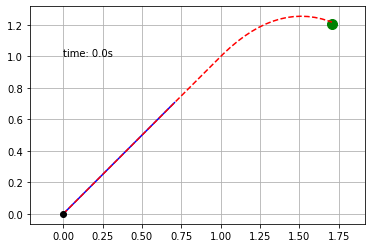

In [57]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

path = np.zeros((2, 2))
path[:,0] = np.linspace(0, 0.707, 2)
for i in range(len(path)):
    path[i, 1] = path[i, 0]
target = np.array([0.707+x_t, 0.707+z_t])

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(100)

def animate(t):
    ax.clear()
    plt.grid()
    
    # Path
    plt.plot(path[:,0], path[:,1], 'b-')
    # target
    plt.plot(target[0], target[1], 'og', markersize=10)
    # trajectory
    plt.plot(state_log[::sampling,0], state_log[::sampling,1], 'r--')
    
    # current position
    plt.plot(state_log[sampling*t,0], state_log[sampling*t,1], 'ko')
    plt.arrow(state_log[sampling*t,0], state_log[sampling*t,1], state_log[sampling*t,2], state_log[sampling*t,3])
    plt.text(0,1,"time: {:.1f}s".format(t*dt*sampling))
    
    
time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

HTML(anim.to_jshtml())